## 3001 Final Project - Car Insurance Fraud Detection

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time

***
### Exploratory Data Analysis

In [ ]:
data = pd.read_csv('insurance_fraud.csv')

In [ ]:
start_time=time.time()
print(data.corr()['fraud'].sort_values(ascending = False))
end_time=time.time()
print('time:',end_time-start_time )
#time: 0.0205s

fraud                      1.000000
past_num_of_claims         0.118596
address_change_ind         0.072249
age_of_vehicle             0.052197
policy_report_filed_ind    0.030132
vehicle_weight             0.009484
claim_number               0.007354
liab_prct                  0.001463
vehicle_price              0.000746
claim_est_payout          -0.016708
zip_code                  -0.032322
annual_income             -0.045646
safty_rating              -0.050729
age_of_driver             -0.059291
witness_present_ind       -0.074150
marital_status            -0.078435
high_education_ind        -0.098350
Name: fraud, dtype: float64
time: 0.02732086181640625


In [ ]:
start_time=time.time()
corr=data.corr()
print(corr['fraud'].sort_values(ascending = False))
end_time=time.time()
print('time:',end_time-start_time )
#time: 0.0223s

fraud                      1.000000
past_num_of_claims         0.118596
address_change_ind         0.072249
age_of_vehicle             0.052197
policy_report_filed_ind    0.030132
vehicle_weight             0.009484
claim_number               0.007354
liab_prct                  0.001463
vehicle_price              0.000746
claim_est_payout          -0.016708
zip_code                  -0.032322
annual_income             -0.045646
safty_rating              -0.050729
age_of_driver             -0.059291
witness_present_ind       -0.074150
marital_status            -0.078435
high_education_ind        -0.098350
Name: fraud, dtype: float64
time: 0.022704124450683594


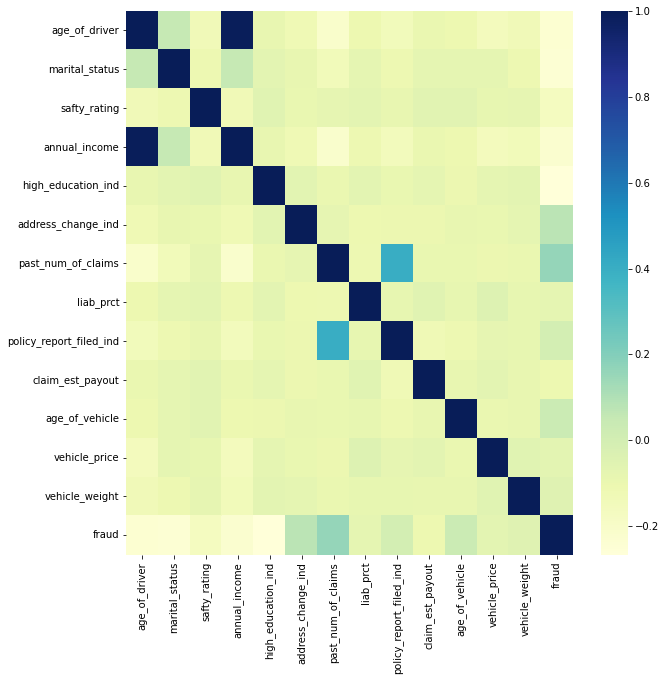

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(corr.corr(),cmap="YlGnBu")

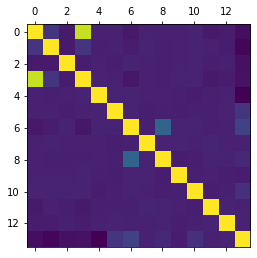

In [ ]:
plt.matshow(data.corr())
plt.show()

#### Column Features

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             17998 non-null  int64  
 1   age_of_driver            17998 non-null  int64  
 2   gender                   17998 non-null  object 
 3   marital_status           17993 non-null  float64
 4   safty_rating             17998 non-null  int64  
 5   annual_income            17998 non-null  int64  
 6   high_education_ind       17998 non-null  int64  
 7   address_change_ind       17998 non-null  int64  
 8   living_status            17998 non-null  object 
 9   zip_code                 17998 non-null  int64  
 10  claim_date               17998 non-null  object 
 11  claim_day_of_week        17998 non-null  object 
 12  accident_site            17998 non-null  object 
 13  past_num_of_claims       17998 non-null  int64  
 14  witness_present_ind   

In [ ]:
data.dtypes

age_of_driver                int64
gender                      object
marital_status             float64
safty_rating                 int64
annual_income                int64
high_education_ind           int64
address_change_ind           int64
living_status               object
claim_day_of_week           object
accident_site               object
past_num_of_claims           int64
witness_present_ind         object
liab_prct                    int64
channel                     object
policy_report_filed_ind      int64
claim_est_payout           float64
age_of_vehicle             float64
vehicle_category            object
vehicle_price              float64
vehicle_color               object
vehicle_weight             float64
fraud                        int64
dtype: object

> Since claim_number column does not contain predictive information regarding the fraud indicator, we could safely drop the column; We lack the tools to extract useful geographical information from the zip_code column. To avoid a sparse matrix at training and introducing noise into our model, we drop the zip_code column; Likewise, we are not going to work with time-series data, plus we have the day of week information, so we drop the claim_data columns.

In [ ]:
data.drop(columns=['claim_number','zip_code', 'claim_date'], inplace=True)

In [ ]:
data.nunique()

age_of_driver                 87
gender                         2
marital_status                 2
safty_rating                 100
annual_income               2693
high_education_ind             2
address_change_ind             2
living_status                  2
claim_day_of_week              7
accident_site                  3
past_num_of_claims             7
witness_present_ind            2
liab_prct                    101
channel                        3
policy_report_filed_ind        2
claim_est_payout           17981
age_of_vehicle                17
vehicle_category               3
vehicle_price              17998
vehicle_color                  7
vehicle_weight             17998
fraud                          2
dtype: int64

#### Missing Values

In [ ]:
data.isna().sum(axis=0)

age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

> The dataset does not have many missing values, so we intend to use the sklearn.impute.SimpleImputer package to fill the missing values. More specifically, for marital_status, claim_est_payout, and age_of_vehicle, we would replace missing values using the median along each column. For witness_present_id, since it has far more missing values than other columns and the missing value itself contains some information regarding whether the insurance claim is fraudulent, we decide to fill the NaN with 'Missing_witness_ind' 

In [ ]:
data1=data
start_time=time.time()
for i in range(len(data1.iloc[:,11])):
  if data1.iloc[i,11]==1:
    data1.iloc[i,11]='Has_witness'
  elif data.iloc[i,11]==0:
    data1.iloc[i,11]='No_witness'
  else :
    data1.iloc[i,11]='Missing_witness'
   
end_time=time.time()
print('time:',end_time-start_time,'s')
#time: 12.361s

time: 12.361020565032959


In [ ]:
start_time=time.time()
def witness_column_transform(x):
    if x == 1:
        return 'Has_witness'
    elif x == 0:
        return 'No_witness'
    else:
        return 'Missing_witness'
data['witness_present_ind'] = data1['witness_present_ind'].map(witness_column_transform)
end_time=time.time()
print('time:',end_time-start_time,'s')
#time: 0.009s

time: 0.008948564529418945


In [ ]:
np.unique(data1.iloc[:,11])


array(['Has_witness', 'Missing_witness', 'No_witness'], dtype=object)

In [ ]:
data[['age_of_driver','gender','marital_status','safty_rating','annual_income','high_education_ind','address_change_ind','living_status','claim_day_of_week','accident_site','past_num_of_claims','witness_present_ind','liab_prct','channel','policy_report_filed_ind','claim_est_payout','age_of_vehicle','vehicle_category','vehicle_price','vehicle_color','vehicle_weight']].describe()

,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight
count,17998.000000,17993.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17981.000000,17990.000000,17998.000000,17998.000000
mean,43.695466,0.712722,73.562951,37367.655684,0.699189,0.577286,0.505001,49.423269,0.600678,4975.792083,5.008060,23089.123114,23031.322385
std,11.959819,0.452505,15.346807,2957.297249,0.458623,0.494004,0.955504,33.678470,0.489773,2215.706510,2.258391,11988.429767,12052.385584
min,18.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.639432,0.000000,2457.329316,2429.429302
25%,35.000000,0.000000,65.000000,35554.000000,0.000000,0.000000,0.000000,17.000000,0.000000,3337.029436,3.000000,14279.574850,14164.122133
50%,43.000000,1.000000,76.000000,37610.000000,1.000000,1.000000,0.000000,50.000000,1.000000,4668.796318,5.000000,20948.879250,20838.150260
75%,51.000000,1.000000,85.000000,39318.000000,1.000000,1.000000,1.000000,81.000000,1.000000,6255.901066,6.000000,29562.232780,29430.446293
max,229.000000,1.000000,100.000000,54333.000000,1.000000,1.000000,6.000000,100.000000,1.000000,17218.345010,16.000000,127063.506000,123016.650400


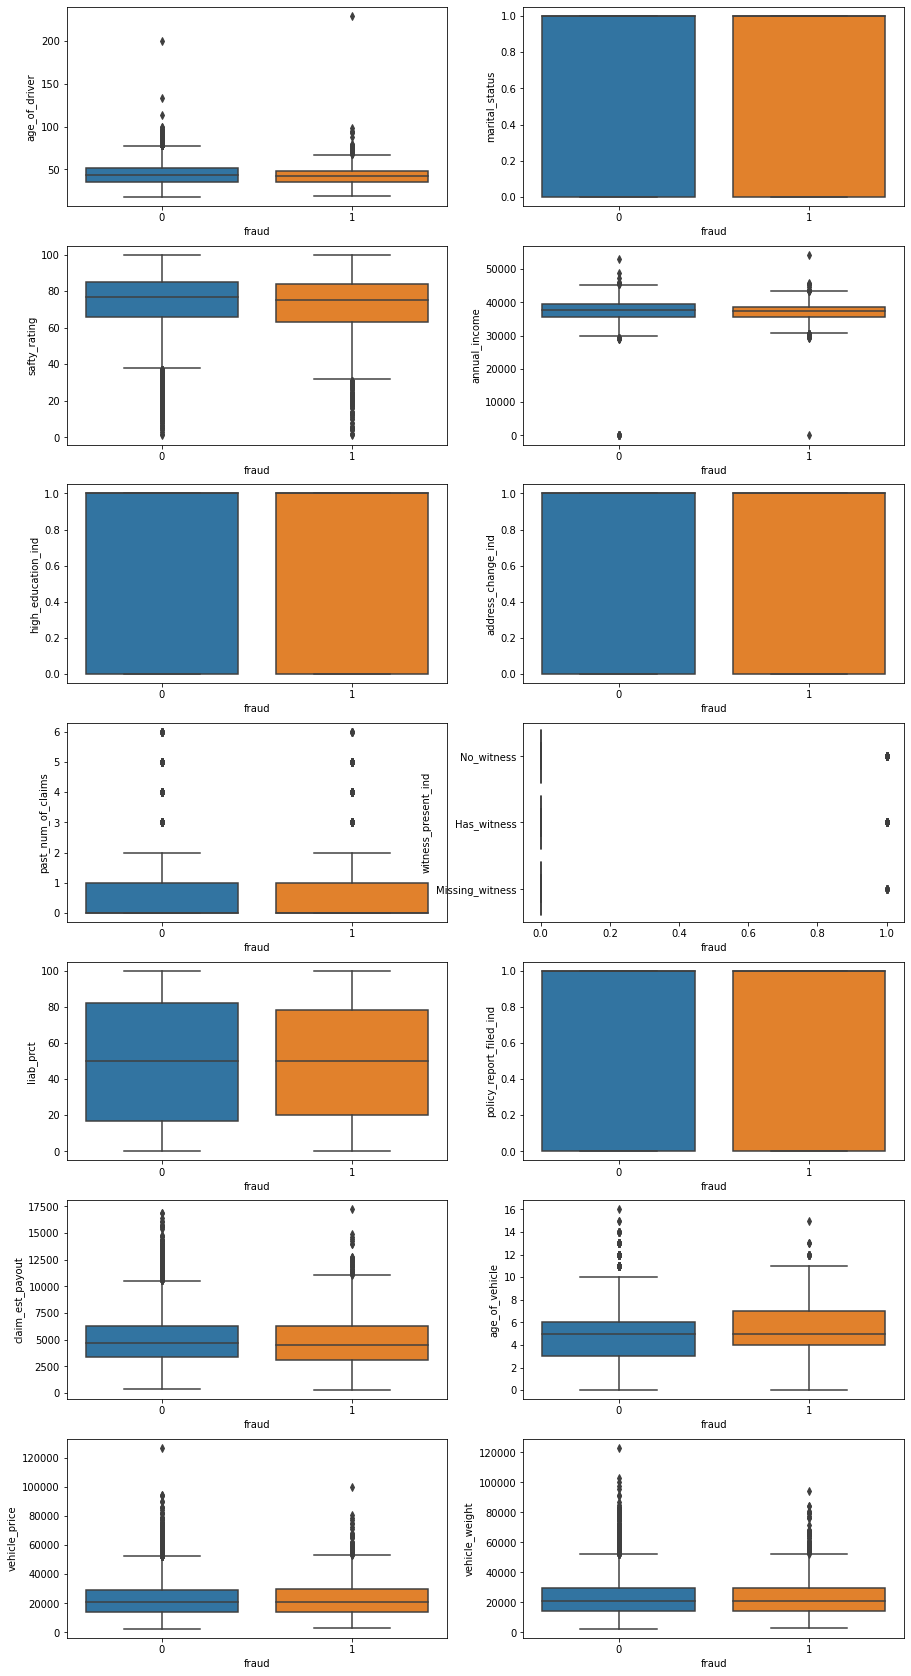

In [ ]:
_,axss = plt.subplots(7,2, figsize=[15,30])
sns.boxplot(x='fraud', y ='age_of_driver', data=data, ax=axss[0][0])
sns.boxplot(x='fraud', y ='marital_status', data=data, ax=axss[0][1])
sns.boxplot(x='fraud', y ='safty_rating', data=data, ax=axss[1][0])
sns.boxplot(x='fraud', y ='annual_income', data=data, ax=axss[1][1])
sns.boxplot(x='fraud', y ='high_education_ind', data=data, ax=axss[2][0])
sns.boxplot(x='fraud', y ='address_change_ind', data=data, ax=axss[2][1])
sns.boxplot(x='fraud', y ='past_num_of_claims', data=data, ax=axss[3][0])
sns.boxplot(x='fraud', y ='witness_present_ind', data=data, ax=axss[3][1])
sns.boxplot(x='fraud', y ='liab_prct', data=data, ax=axss[4][0])
sns.boxplot(x='fraud', y ='policy_report_filed_ind', data=data, ax=axss[4][1])
sns.boxplot(x='fraud', y ='claim_est_payout', data=data, ax=axss[5][0])
sns.boxplot(x='fraud', y ='age_of_vehicle', data=data, ax=axss[5][1])
sns.boxplot(x='fraud', y ='vehicle_price', data=data, ax=axss[6][0])
sns.boxplot(x='fraud', y ='vehicle_weight', data=data, ax=axss[6][1])

***
### Create Pipeline

#### Split Data

In [ ]:
X = data.drop('fraud',axis=1)
y = data['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#### Preprocessor

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])
# mariatal_status is an indicator variable with missing values
marital_status_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [ ]:
# extract the numerical features
numerical_features = list(X.select_dtypes(include=['int64','float64']).columns)
# exclude indicators 
to_exclude = ['marital_status','high_education_ind','address_change_ind','policy_report_filed_ind']
for i in to_exclude:
    numerical_features.remove(i)
    
# extract the categorical features
categorical_features = list(X.select_dtypes(include=['object']).columns)

# marital_status
marital_status_feature = ['marital_status']

In [ ]:
preprocessor = ColumnTransformer(
   transformers=[
       ('numerical', numeric_transformer, numerical_features)
       ,('categorical', categorical_transformer, categorical_features)
       ,('marital', marital_status_transformer, marital_status_feature)
], remainder='passthrough')

In [ ]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age_of_driver', 'safty_rating',
                                  'annual_income', 'past_num_of_claims',
                                  'liab_prct', 'claim_est_payout',
                                  'age_of_vehicle', 'vehicle_price',
                                  'vehicle_weight']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['gender', 'living_status',
                                  'claim_day_of_week', 'accident_site',
                              

#### Estimator - Logistic Regression

In [ ]:
pipeline_logisticReg = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', LogisticRegression())
])
param_grid_logisticReg = [
    {
        "classifier__C": [ 12.5,13.0,13.5,14.0,14.5,15.0],
        "classifier__class_weight": ['balanced', None]
    }
]

In [ ]:
grid_search_logisticReg = GridSearchCV(pipeline_logisticReg, param_grid_logisticReg, scoring='roc_auc', cv=10)
grid_search_logisticReg.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [ ]:
print(grid_search_logisticReg.best_params_)
print(f'Best logisticReg auc Score: {grid_search_logisticReg.best_score_}')
LR = grid_search_logisticReg.best_estimator_

{'classifier__C': 13.5, 'classifier__class_weight': None}
Best logisticReg auc Score: 0.6996083550704053


#### Estimator - SVM

In [ ]:
pipeline_svm = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', LinearSVC(dual=False))
])
param_grid_svm = [
    {
        "classifier__C": [0.7,0.75,0.8,0.85, 0.9,1],
        "classifier__class_weight": ['balanced', None]
    }
]

In [ ]:
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring='roc_auc', cv=10, verbose=True)
grid_search_svm.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 12 candidates, totalling 120 fits


''

In [ ]:
print(grid_search_svm.best_params_)
print(f'Best linearSvr auc Score: {grid_search_svm.best_score_}')
svm = grid_search_svm.best_estimator_

{'classifier__C': 0.85, 'classifier__class_weight': None}
Best linearSvr auc Score: 0.6990082296568663


#### Estimator - Random Forest

In [ ]:
pipeline_rf = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', RandomForestClassifier(max_features='sqrt'))
])
param_grid_rf = [
    {"classifier__oob_score":[True,False],
        "classifier__n_estimators": [150,175,200,225,250]
        
        
    }
]


In [ ]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring='roc_auc', cv=10, verbose=True)
grid_search_rf.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 10 candidates, totalling 100 fits


''

In [ ]:
print(grid_search_rf.best_params_)
print(f'Best rf auc Score: {grid_search_rf.best_score_}')
rf = grid_search_rf.best_estimator_

{'classifier__n_estimators': 200, 'classifier__oob_score': True}
Best rf auc Score: 0.6881320054792173


#### Estimator - Adaboost

In [ ]:
base_tree = DecisionTreeClassifier(max_depth=1)

pipeline_Ada = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', AdaBoostClassifier(base_estimator=base_tree))
])
param_grid_Ada = [
    {  
        "classifier__n_estimators": [25,30,40,50,75],
        "classifier__learning_rate": [0.1,0.25,0.4,0.5,0.6,0.75]
    }
]

In [ ]:
grid_search_Ada = GridSearchCV(pipeline_Ada, param_grid_Ada, scoring='roc_auc', cv=10, verbose=True)
grid_search_Ada.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 30 candidates, totalling 300 fits


KeyboardInterrupt: ignored

In [ ]:
print(grid_search_Ada.best_params_)
print(f'Best ada auc Score: {grid_search_Ada.best_score_}')
Ada = grid_search_Ada.best_estimator_

#### Output Data For Experiment Use

In [ ]:
x_train_data = preprocessor.fit_transform(X_train)
x_test_data = preprocessor.transform(X_test)

In [ ]:
training_data = np.hstack((x_train_data,np.array(y_train).reshape(-1,1)))
testing_data = np.hstack((x_test_data,np.array(y_test).reshape(-1,1)))
np.savetxt("training.txt", training_data)
np.savetxt("testing.txt", testing_data)

***
### Evaluation on Testing

In [ ]:
Models = {'logisticReg':LR, 'SVM':svm, 'randomForest':rf, 'AdaBoost':Ada}

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3052
           1       0.42      0.03      0.06       548

    accuracy                           0.85      3600
   macro avg       0.64      0.51      0.49      3600
weighted avg       0.79      0.85      0.79      3600



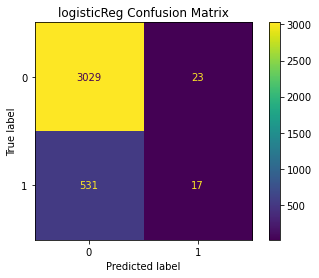

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3052
           1       0.33      0.00      0.01       548

    accuracy                           0.85      3600
   macro avg       0.59      0.50      0.46      3600
weighted avg       0.77      0.85      0.78      3600



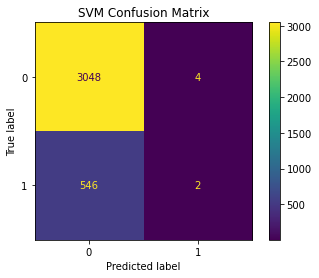

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3052
           1       1.00      0.00      0.01       548

    accuracy                           0.85      3600
   macro avg       0.92      0.50      0.46      3600
weighted avg       0.87      0.85      0.78      3600



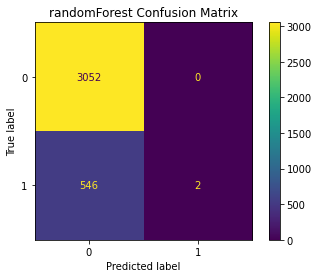

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3052
           1       0.52      0.03      0.06       548

    accuracy                           0.85      3600
   macro avg       0.68      0.51      0.49      3600
weighted avg       0.80      0.85      0.79      3600



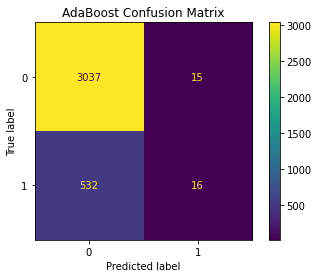

In [ ]:
for i in Models.items():
    y_preds = i[1].predict(X_test)
    print(classification_report(y_test, y_preds))
    cm = confusion_matrix(y_test, y_preds)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.title(f"{i[0]} Confusion Matrix")
    plt.show()

***
### SMOTE

In [ ]:
# conda install -c conda-forge imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
training_data = np.loadtxt('training.txt')
testing_data = np.loadtxt('testing.txt')

In [ ]:
X_train, y_train = training_data[:,:-1], training_data[:,-1]
X_test, y_test = testing_data[:,:-1], testing_data[:,-1]

In [ ]:
LR_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', LogisticRegression())
    ])

param_grid_logisticReg = [
    {
      
        "classifier__C": [ 0.05,0.075,0.1,0.15,0.2],
        "classifier__class_weight": ['balanced', None]
    }
]

grid_search_LR_smote = GridSearchCV(LR_smote, param_grid_logisticReg, scoring='roc_auc', cv=10)
grid_search_LR_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [ ]:
print(grid_search_LR_smote.best_params_)
print(f'Best logisticReg auc Score: {grid_search_LR_smote.best_score_}')
LR_ = grid_search_LR_smote.best_estimator_

{'classifier__C': 0.2, 'classifier__class_weight': 'balanced'}
Best logisticReg auc Score: 0.6959899003244868


In [ ]:
svm_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', LinearSVC(dual=False))
    ])

param_grid_svm = [
    {
       "classifier__C": [0.8,0.85, 0.9,1,1.1],
        "classifier__class_weight": ['balanced', None]
    }
]

grid_search_svm_smote = GridSearchCV(svm_smote, param_grid_svm, scoring='roc_auc', cv=10)
grid_search_svm_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [ ]:
print(grid_search_svm_smote.best_params_)
print(f'Best svm_smote auc Score: {grid_search_svm_smote.best_score_}')
SVM_ = grid_search_svm_smote.best_estimator_

{'classifier__C': 1, 'classifier__class_weight': None}
Best svm_smote auc Score: 0.6950794614102039


In [ ]:
RF_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', RandomForestClassifier(max_features='sqrt'))
    ])

param_grid_rf = [
    {
       "classifier__oob_score":[True,False],
        "classifier__n_estimators": [150,175,200,225,250]
    }
]

grid_search_RF_smote = GridSearchCV(RF_smote, param_grid_rf, scoring='roc_auc', cv=10)
grid_search_RF_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [ ]:
print(grid_search_RF_smote.best_params_)
print(f'Best RF_smote auc Score: {grid_search_RF_smote.best_score_}')
RF_ = grid_search_RF_smote.best_estimator_

{'classifier__n_estimators': 225, 'classifier__oob_score': True}
Best RF_smote auc Score: 0.6890014163097316


In [ ]:
base_tree = DecisionTreeClassifier(max_depth=1)
Ada_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', AdaBoostClassifier(base_estimator=base_tree))
    ])

param_grid_Ada = [
    {  
        "classifier__n_estimators": [150,175,200,225,250],
        "classifier__learning_rate": [0.5,0.75,1,1.25,1.5]
     
      
    }
]

In [ ]:
grid_search_Ada_smote = GridSearchCV(Ada_smote, param_grid_Ada, scoring='roc_auc', cv=10, verbose=True)
grid_search_Ada_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 25 candidates, totalling 250 fits


''

In [ ]:
print(grid_search_Ada_smote.best_params_)
print(f'Best Ada_smote auc Score: {grid_search_Ada_smote.best_score_}')
Ada_ = grid_search_Ada_smote.best_estimator_

{'classifier__learning_rate': 1, 'classifier__n_estimators': 175}
Best Ada_smote auc Score: 0.7151349188644595


In [ ]:
Models_smote = {'logisticReg_smote':LR_, 'SVM_smomte':SVM_, 'randomForest_smote':RF_, 'AdaBoost_smote':Ada_}

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.75      3052
         1.0       0.24      0.66      0.35       548

    accuracy                           0.64      3600
   macro avg       0.58      0.64      0.55      3600
weighted avg       0.81      0.64      0.69      3600



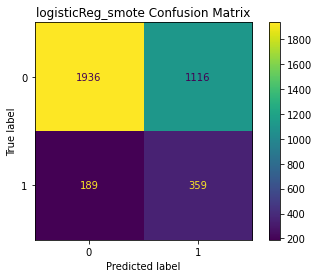

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.75      3052
         1.0       0.24      0.66      0.36       548

    accuracy                           0.63      3600
   macro avg       0.58      0.65      0.55      3600
weighted avg       0.81      0.63      0.69      3600



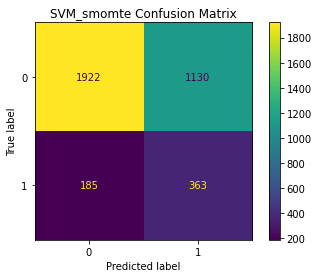

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      3052
         1.0       0.34      0.02      0.03       548

    accuracy                           0.85      3600
   macro avg       0.60      0.51      0.48      3600
weighted avg       0.77      0.85      0.78      3600



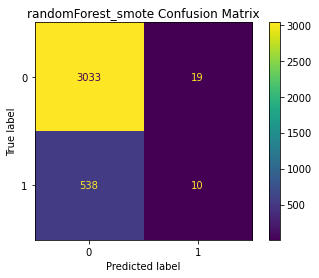

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91      3052
         1.0       0.46      0.12      0.19       548

    accuracy                           0.84      3600
   macro avg       0.66      0.55      0.55      3600
weighted avg       0.80      0.84      0.80      3600



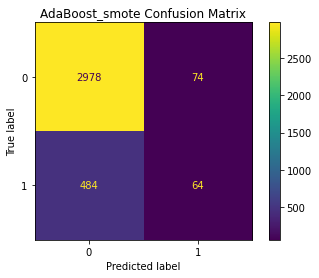

In [ ]:
for i in Models_smote.items():
    y_preds = i[1].predict(X_test)
    print(classification_report(y_test, y_preds))
    cm = confusion_matrix(y_test, y_preds)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.title(f"{i[0]} Confusion Matrix")
    plt.show()